# Foot Traffic Forecasting Pipeline

This notebook forecasts hourly pedestrian counts for multiple streets in Würzburg using LightGBM and XGBoost models.

**Pipeline Overview:**
1. **Setup** - Load configuration and modules
2. **Load Data** - Read train/test/solution CSVs
3. **Feature Engineering** - Create all features from raw data
4. **Model Training** - Train models and evaluate on validation set
5. **Generate Submission** - Create predictions for test set
6. **Optional: Performance Analysis** - Score against solution
7. **Optional: Uncertainty Quantification** - Compute prediction intervals
8. **Optional: SHAP Analysis** - Feature importance visualization

---

## Quick Start

1. Open `config.py` and set `BASE_PATH` to your project root directory
2. Run all cells in sections 1-5 to generate predictions
3. Optionally run sections 6-8 for analysis

---
## 1. Setup

In [1]:
# Standard library imports
import copy
import pickle
import os

# Data manipulation
import pandas as pd
import numpy as np

# Models
import lightgbm as lgb
import xgboost as xgb

# Hyperparameter tuning
from scipy.stats import uniform, randint
from skopt.space import Real, Integer

# Configuration
import config
from config import (
    DATA_PATH, GENERAL_DATA_PATH, OUTPUT_PATH,
    MODELS_TO_USE, TUNE_MODELS, N_SPLITS, N_ITER, N_POINTS_BAYES, N_JOBS, VERBOSE,
    RETRAIN_ON_VAL, DESEASONALIZE, TARGETS,
    LGB_PARAMS, XGB_PARAMS
)

# Custom modules
from src.features import create_all_features, get_feature_columns
from src.modeling import (
    get_cv_splits, tune_model_bayes, get_best_model,
    train_models_for_target,
    compute_seasonal_factors, apply_deseasonalization, reverse_deseasonalization
)
from src.evaluation import display_target_metrics, display_feature_importance
from src.visualization import plot_model_comparison

In [2]:
# Verify paths are configured correctly
print("=" * 60)
print("PATH CONFIGURATION")
print("=" * 60)
print(f"Data path:    {DATA_PATH}")
print(f"General data: {GENERAL_DATA_PATH}")
print(f"Output path:  {OUTPUT_PATH}")
print()
print("Checking paths exist...")
assert DATA_PATH.exists(), f"DATA_PATH does not exist: {DATA_PATH}"
assert GENERAL_DATA_PATH.exists(), f"GENERAL_DATA_PATH does not exist: {GENERAL_DATA_PATH}"
print("All paths verified!")
print()
print("=" * 60)
print("MODEL CONFIGURATION")
print("=" * 60)
print(f"Models to use:     {MODELS_TO_USE}")
print(f"Tune models:       {TUNE_MODELS}")
print(f"Retrain on val:    {RETRAIN_ON_VAL}")
print(f"Deseasonalize:     {DESEASONALIZE}")

PATH CONFIGURATION
Data path:    data_foot_traffic
General data: data_general
Output path:  data_foot_traffic/submission.csv

Checking paths exist...
All paths verified!

MODEL CONFIGURATION
Models to use:     ['xgb']
Tune models:       False
Retrain on val:    False
Deseasonalize:     False


---
## 2. Load Data

In [3]:
# Load all datasets
print("Loading datasets...")

train_df = pd.read_csv(DATA_PATH / 'train.csv')
test_df = pd.read_csv(DATA_PATH / 'test.csv')
solution_df = pd.read_csv(DATA_PATH / 'solution.csv')
val_test_actuals = pd.read_csv(DATA_PATH / 'val_test_actuals.csv')

# Extract public test data (can be used for training)
X_publicTest = test_df[test_df['id'].isin(solution_df[solution_df.Usage == 'Public'].id)]
X_publicTest = X_publicTest.merge(solution_df[solution_df.Usage == 'Public'], on='id', how='left')
X_publicTest.drop(columns=['Usage'], inplace=True)

# Keep a copy of test_df for submission
test_df_submission = copy.deepcopy(test_df)

print(f"Train samples: {len(train_df):,}")
print(f"Test samples:  {len(test_df):,}")
print(f"Public test samples (usable for training): {len(X_publicTest):,}")

Loading datasets...
Train samples: 92,901
Test samples:  1,008
Public test samples (usable for training): 504


In [4]:
# OPTIONAL: Augment training data with public test labels
# This uses the public leaderboard portion of the test set as additional training data

train_df = pd.concat([train_df, X_publicTest], ignore_index=True).reset_index(drop=True)

# Remove public test IDs from test_df (since they're now in training)
test_df = test_df[~test_df['id'].isin(X_publicTest['id'])].reset_index(drop=True)

print(f"Updated train samples: {len(train_df):,}")
print(f"Updated test samples:  {len(test_df):,}")

Updated train samples: 93,405
Updated test samples:  504


---
## 3. Feature Engineering

In [5]:
print("Creating training features...")
train_df = create_all_features(train_df)

print("\nCreating test features...")
test_df = create_all_features(test_df)

print("\nCreating submission test features...")
test_df_submission = create_all_features(test_df_submission)

print(f"\nTrain shape after features: {train_df.shape}")
print(f"Test shape after features: {test_df.shape}")

Creating training features...


Encoding weekday
Encoding incidents
Encoding collection_type

Creating test features...
Encoding weekday
Encoding incidents
Encoding collection_type

Creating submission test features...
Encoding weekday
Encoding incidents
Encoding collection_type

Train shape after features: (93402, 90)
Test shape after features: (501, 84)


In [6]:
# Align test dataframes to match training dataframe columns
# This ensures one-hot encoded columns are consistent between train and test
from src.features import align_dataframe_columns

print("\nAligning test dataframe columns with training dataframe...")
test_df = align_dataframe_columns(train_df, test_df)

print("\nAligning submission test dataframe columns with training dataframe...")
test_df_submission = align_dataframe_columns(train_df, test_df_submission)

print(f"\nFinal shapes:")
print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")
print(f"Test submission: {test_df_submission.shape}")


Aligning test dataframe columns with training dataframe...
Adding 3 missing columns to test set: ['weather_fog', 'weather_sleet', 'weather_wind']

Aligning submission test dataframe columns with training dataframe...
Adding 3 missing columns to test set: ['weather_fog', 'weather_sleet', 'weather_wind']

Final shapes:
Train: (93402, 90)
Test: (501, 87)
Test submission: (1005, 87)


In [7]:
# Prepare train/validation split
# The last week of data per street is used for validation

cv_splits = get_cv_splits(train_df, n_splits=1, len_split=168)  # 168 hours = 1 week
train_idx, val_idx = cv_splits[0]

X_train = train_df.loc[train_idx].copy()
X_val = train_df.loc[val_idx].copy()

# Get feature columns
feature_cols = get_feature_columns(X_train)

print(f"\nTraining samples: {len(X_train):,}")
print(f"Validation samples: {len(X_val):,}")
print(f"Number of features: {len(feature_cols)}")

Removed columns: {'collection_type', 'date', 'id', 'weekday', 'year', 'day', 'month', 'day_of_week', 'datetime', 'n_pedestrians_towards', 'n_pedestrians_away', 'streetname', 'incidents', 'n_pedestrians'}

Training samples: 92,898
Validation samples: 504
Number of features: 76


---
## 4. Model Training

This section trains models for each target variable and selects the best performer.

In [8]:
# Define models with hyperparameters from config
models = {
    'lgb': lgb.LGBMRegressor(**LGB_PARAMS),
    'xgb': xgb.XGBRegressor(**XGB_PARAMS)
}

# Hyperparameter search spaces (used only if TUNE_MODELS = True)
search_spaces = {
    'lgb': {
        'n_estimators': Integer(100, 1000),
        'learning_rate': Real(0.01, 0.3, prior='uniform'),
        'max_depth': Integer(4, 11),
        'num_leaves': Integer(50, 300),
        'subsample': Real(0.4, 1, prior='uniform'),
        'colsample_bytree': Real(0.4, 1, prior='uniform'),
        'min_child_samples': Integer(1, 50),
        'reg_lambda': Real(0.1, 20, prior='uniform'),
    },
    'xgb': {
        'n_estimators': Integer(100, 1000),
        'learning_rate': Real(0.01, 0.3, prior='uniform'),
        'max_depth': Integer(4, 11),
        'subsample': Real(0.4, 1, prior='uniform'),
        'colsample_bytree': Real(0.4, 1, prior='uniform'),
        'min_child_weight': Integer(1, 50),
        'reg_lambda': Real(0.1, 20, prior='uniform'),
    }
}

# Filter to selected models
models_selected = {name: model for name, model in models.items() if name in MODELS_TO_USE}
print(f"Training models: {list(models_selected.keys())}")

Training models: ['xgb']


In [9]:
# Main training loop
best_models = {}
best_models_saved = {}
target_models = {}
all_val_predictions = {}
all_test_predictions = {}
all_submission_predictions = {}

for target in TARGETS:
    print(f"\n{'='*60}")
    print(f"Processing target: {target}")
    print(f"{'='*60}")

    # Prepare data (with optional deseasonalization)
    if DESEASONALIZE:
        seasonal_factors = compute_seasonal_factors(X_train, target)
        X_train_target = apply_deseasonalization(X_train, target, seasonal_factors)
        X_val_target = apply_deseasonalization(X_val, target, seasonal_factors)
        test_df_target = test_df.merge(seasonal_factors, on=['streetname', 'weekday', 'hour'], how='left')
        test_df_sub_target = test_df_submission.merge(seasonal_factors, on=['streetname', 'weekday', 'hour'], how='left')
    else:
        X_train_target = X_train
        X_val_target = X_val
        test_df_target = test_df
        test_df_sub_target = test_df_submission

    # Train all models for this target
    val_predictions, test_predictions, models_fitted = train_models_for_target(
        X_train=X_train_target,
        X_val=X_val_target,
        test_df=test_df_target,
        target=target,
        feature_cols=feature_cols,
        models_selected=models_selected,
        search_spaces=search_spaces,
        tune_models=TUNE_MODELS,
        retrain_on_val=RETRAIN_ON_VAL,
        n_splits=N_SPLITS,
        n_iter=N_ITER,
        n_points=N_POINTS_BAYES,
        n_jobs=N_JOBS,
        verbose=VERBOSE
    )

    # Reverse deseasonalization if applied
    if DESEASONALIZE:
        for model_name in val_predictions:
            val_predictions[model_name][target] = reverse_deseasonalization(
                val_predictions[model_name][target].values,
                X_val_target['seasonal_factor'].values
            )
            val_predictions[model_name][target] = np.clip(val_predictions[model_name][target], a_min=0, a_max=None)

            test_predictions[model_name][target] = reverse_deseasonalization(
                test_predictions[model_name][target].values,
                test_df_target['seasonal_factor'].values
            )
            test_predictions[model_name][target] = np.clip(test_predictions[model_name][target], a_min=0, a_max=None)

    all_val_predictions[target] = val_predictions
    all_test_predictions[target] = test_predictions

    # Display metrics
    print(f"\nMetrics for {target}:")
    display_target_metrics(X_val, val_predictions, target)

    # Select best model
    best_model, best_mse = get_best_model(models_fitted, X_val[target], val_predictions)
    best_models[target] = best_model
    print(f"\nBest model for {target}: {best_model.upper()} (MSE: {best_mse:.2f})")

    # Feature importance
    if best_model in ['rf', 'lgb', 'xgb']:
        display_feature_importance(models_fitted[best_model], feature_cols, best_model, target)

    # Generate submission predictions using best model
    submission_preds = models_fitted[best_model].predict(test_df_sub_target[feature_cols])
    if DESEASONALIZE:
        submission_preds = reverse_deseasonalization(submission_preds, test_df_sub_target['seasonal_factor'].values)
    submission_preds = np.clip(submission_preds, a_min=0, a_max=None)
    all_submission_predictions[target] = pd.DataFrame({target: submission_preds}, index=test_df_submission.index)

    target_models[target] = models_fitted
    best_models_saved[target] = copy.deepcopy(models_fitted[best_model])

# Save trained models
with open(DATA_PATH / 'best_models.pkl', 'wb') as f:
    pickle.dump(best_models_saved, f)
print(f"\nModels saved to {DATA_PATH / 'best_models.pkl'}")


Processing target: n_pedestrians

Training XGB...
Training complete.

Metrics for n_pedestrians:

Results for n_pedestrians

Overall Metrics:
Model      MSE   RMSE   MAE MAPE     R2
  XGB 18024.51 134.26 59.51 inf% 0.9802

Street-wise Metrics:

schoenbornstrasse:
Model      MSE   RMSE   MAE MAPE     R2
  XGB 43454.61 208.46 82.92 inf% 0.9732

spiegelstrasse:
Model     MSE  RMSE   MAE   MAPE     R2
  XGB 4258.93 65.26 43.49 16.49% 0.9853

kaiserstrasse:
Model     MSE  RMSE   MAE   MAPE     R2
  XGB 6359.99 79.75 52.14 35.17% 0.9913

Best model for n_pedestrians: XGB (MSE: 18024.51)

Top 10 Important Features for XGB - n_pedestrians:
                      Feature  Importance
             is_tourist_hours    0.549207
            is_shopping_hours    0.215064
             is_working_hours    0.020256
                     is_night    0.019784
     street_schoenbornstrasse    0.019176
                   is_weekend    0.014238
                 hour_of_week    0.011469
            is_public_h

In [ ]:
# Visualize predictions vs actuals for train and validation periods
from src.visualization import plot_train_val_predictions

for target in TARGETS:
    print(f"\n{'='*60}")
    print(f"Plotting predictions for {target}")
    print(f"{'='*60}")
    
    # Get best model predictions
    best_model_name = best_models[target]
    train_preds = best_models_saved[target].predict(X_train[feature_cols])
    val_preds = all_val_predictions[target][best_model_name][target].values
    
    # Plot using the visualization function
    plot_train_val_predictions(
        X_train=X_train,
        X_val=X_val,
        train_preds=train_preds,
        val_preds=val_preds,
        target=target,
        sample_size=500,
        save_path=f'plots/{target}_train_val_predictions.png'
    )
    
    print(f"Saved plot to plots/{target}_train_val_predictions.png")

---
## 5. Generate Submission

In [11]:
# Create submission DataFrame
submission_df = pd.DataFrame({'id': test_df_submission['id']})

for target in TARGETS:
    submission_df[target] = all_submission_predictions[target][target].round(1)

submission_df.to_csv(OUTPUT_PATH, index=False)

print(f"Submission file saved to: {OUTPUT_PATH}")
print(f"\nSubmission shape: {submission_df.shape}")
print("\nSample predictions:")
submission_df.head(10)

Submission file saved to: data_foot_traffic/submission.csv

Submission shape: (1005, 4)

Sample predictions:


,id,n_pedestrians,n_pedestrians_towards,n_pedestrians_away
0,kaiserstrasse_2025-02-03_1,11.6,5.5,7.0
1,spiegelstrasse_2025-02-03_1,1.9,1.2,0.0
2,schoenbornstrasse_2025-02-03_1,10.7,4.8,5.4
3,kaiserstrasse_2025-02-03_2,8.2,2.6,6.1
4,spiegelstrasse_2025-02-03_2,0.0,0.0,0.0
5,schoenbornstrasse_2025-02-03_2,5.1,2.3,2.9
6,spiegelstrasse_2025-02-03_3,0.0,0.0,0.0
7,schoenbornstrasse_2025-02-03_3,3.4,2.0,2.3
8,kaiserstrasse_2025-02-03_3,7.3,2.3,5.6
9,schoenbornstrasse_2025-02-03_4,3.8,1.6,2.5


In [12]:
# Also create a formatted version with additional columns for analysis
test_df_formatting = pd.read_csv(DATA_PATH / 'test.csv')

submission_df_formatted = test_df_formatting.merge(submission_df, on='id', how='left')
submission_df_formatted = submission_df_formatted[[
    'id', 'streetname', 'city', 'date', 'hour', 'weekday',
    'temperature', 'weather_condition', 'incidents', 'collection_type',
    'n_pedestrians', 'n_pedestrians_towards', 'n_pedestrians_away'
]]

submission_df_formatted.to_csv(DATA_PATH / 'pedestrians_val_test_forecasts.csv', index=False)
print(f"Formatted submission saved to: {DATA_PATH / 'pedestrians_val_test_forecasts.csv'}")

Formatted submission saved to: data_foot_traffic/pedestrians_val_test_forecasts.csv


---
## 6. Optional: Performance Analysis

Compare predictions against the solution file to evaluate model performance.

In [12]:
# Load predictions and solution
sub = pd.read_csv(OUTPUT_PATH)
solution = pd.read_csv(DATA_PATH / 'solution.csv')
test_data = pd.read_csv(DATA_PATH / 'test.csv')

# Add hour column for filtering
sub = sub.merge(test_data[['id', 'hour']], on='id', how='left')
solution = solution.merge(test_data[['id', 'hour']], on='id', how='left')

# Split into public (validation) and private (test) sets
solutionVal = solution[solution.Usage == 'Public'].set_index('id').sort_index()
solutionTest = solution[solution.Usage == 'Private'].set_index('id').sort_index()

subVal = sub[sub.id.isin(solutionVal.index)].set_index('id').sort_index()
subTest = sub[sub.id.isin(solutionTest.index)].set_index('id').sort_index()

print(f"Public (Validation) samples: {len(subVal)}")
print(f"Private (Test) samples: {len(subTest)}")

Public (Validation) samples: 501
Private (Test) samples: 504


In [13]:
# Calculate MSE for validation and test sets
mseVal = np.mean((solutionVal[TARGETS] - subVal[TARGETS])**2)
mseTest = np.mean((solutionTest[TARGETS] - subTest[TARGETS])**2)

print("Overall MSE (All Hours):")
print(f"  Validation (Public):  {mseVal.mean():.2f}")
print(f"  Test (Private):       {mseTest.mean():.2f}")

print("\nMSE per Target:")
for target in TARGETS:
    val_mse = np.mean((solutionVal[target] - subVal[target])**2)
    test_mse = np.mean((solutionTest[target] - subTest[target])**2)
    print(f"  {target}:")
    print(f"    Validation: {val_mse:.2f}")
    print(f"    Test:       {test_mse:.2f}")

Overall MSE (All Hours):
  Validation (Public):  30189.55
  Test (Private):       33982.55

MSE per Target:
  n_pedestrians:
    Validation: 58318.01
    Test:       63441.46
  n_pedestrians_towards:
    Validation: 17466.66
    Test:       23650.35
  n_pedestrians_away:
    Validation: 14784.00
    Test:       14855.85


In [14]:
# Filter to daytime hours (8-22) for business-relevant metrics
day_mask_val = subVal['hour'].between(8, 22)
day_mask_test = subTest['hour'].between(8, 22)

subVal_day = subVal[day_mask_val]
subTest_day = subTest[day_mask_test]
solutionVal_day = solutionVal.loc[subVal_day.index]
solutionTest_day = solutionTest.loc[subTest_day.index]

mseVal_day = np.mean((solutionVal_day[TARGETS] - subVal_day[TARGETS])**2)
mseTest_day = np.mean((solutionTest_day[TARGETS] - subTest_day[TARGETS])**2)

print("MSE (Daytime Hours 8-22 Only):")
print(f"  Validation: {mseVal_day.mean():.2f}")
print(f"  Test:       {mseTest_day.mean():.2f}")

MSE (Daytime Hours 8-22 Only):
  Validation: 47786.44
  Test:       53298.27


---
## 7. Optional: Uncertainty Quantification

Compute prediction intervals using error quantiles from training data.

In [15]:
from src.uncertainty import compute_prediction_intervals, check_calibration
from src.visualization import plot_prediction_intervals

In [16]:
# Compute prediction intervals for all targets
quantiles = [0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99, 0.995]

all_pred_results_train = []
all_pred_results_val = []
all_pred_results_test = []

for target in TARGETS:
    print(f"\nComputing prediction intervals for {target}...")
    model = best_models_saved[target]
    
    pred_train, pred_val, pred_test = compute_prediction_intervals(
        train_df=X_train,
        val_df=X_val,
        test_df=test_df,
        model=model,
        feature_cols=feature_cols,
        target=target,
        quantiles=quantiles
    )
    
    all_pred_results_train.append(pred_train)
    all_pred_results_val.append(pred_val)
    all_pred_results_test.append(pred_test)

pred_results_train = pd.concat(all_pred_results_train, ignore_index=True)
pred_results_val = pd.concat(all_pred_results_val, ignore_index=True)
pred_results_test = pd.concat(all_pred_results_test, ignore_index=True)

print(f"\nPrediction intervals computed.")
print(f"Train results shape: {pred_results_train.shape}")
print(f"Val results shape:   {pred_results_val.shape}")
print(f"Test results shape:  {pred_results_test.shape}")


Computing prediction intervals for n_pedestrians...

Computing prediction intervals for n_pedestrians_towards...

Computing prediction intervals for n_pedestrians_away...

Prediction intervals computed.
Train results shape: (3623022, 12)
Val results shape:   (19656, 12)
Test results shape:  (19539, 12)


In [17]:
# Check calibration: empirical coverage vs nominal coverage
print("Calibration Check (Validation Set):")
print("For well-calibrated intervals, empirical coverage should match quantile level.")
print("e.g., 95% quantile should have ~95% of actuals below predicted value.\n")

calibration = check_calibration(pred_results_val)
calibration_pivot = calibration.pivot(index='quantile', columns='target', values='empirical_coverage')
calibration_pivot

Calibration Check (Validation Set):
For well-calibrated intervals, empirical coverage should match quantile level.
e.g., 95% quantile should have ~95% of actuals below predicted value.



target,n_pedestrians,n_pedestrians_away,n_pedestrians_towards
quantile,,,
0.005,0.001984,0.001984,0.000000
0.010,0.001984,0.003968,0.003968
0.025,0.001984,0.007937,0.005952
0.050,0.007937,0.009921,0.009921
0.100,0.015873,0.019841,0.025794
0.250,0.109127,0.146825,0.138889
0.500,0.428571,0.444444,0.420635
0.750,0.783730,0.755952,0.755952
0.900,0.936508,0.936508,0.936508


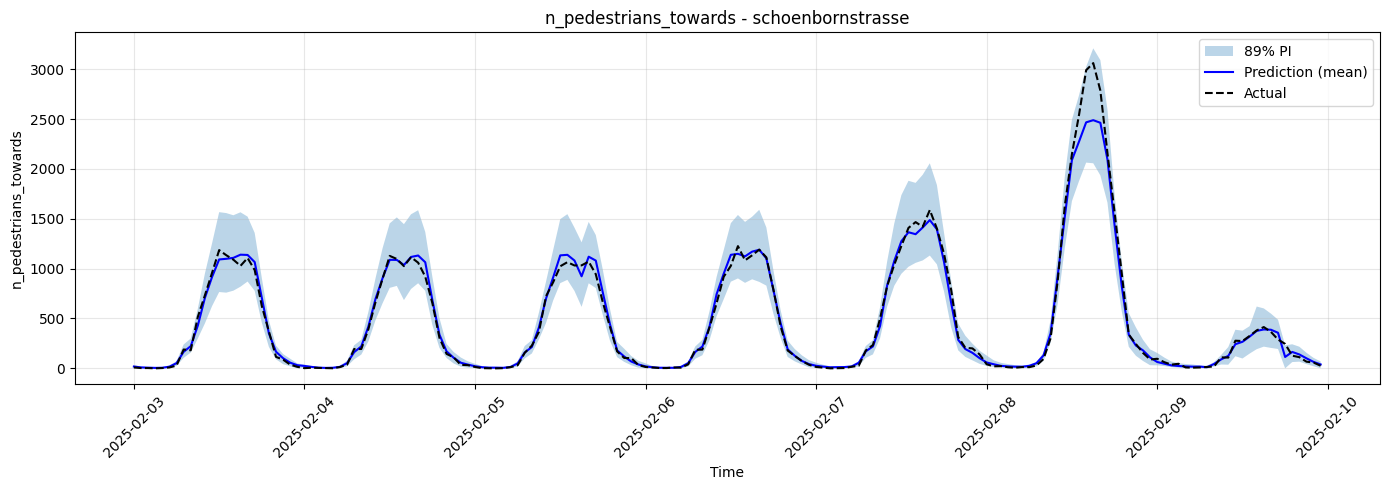

In [18]:
# Plot prediction intervals for a specific street and target
# Adjust parameters as needed

plot_prediction_intervals(
    pred_results_val,
    target="n_pedestrians_towards",
    street="schoenbornstrasse",
    lower_q=0.05,
    upper_q=0.95
)

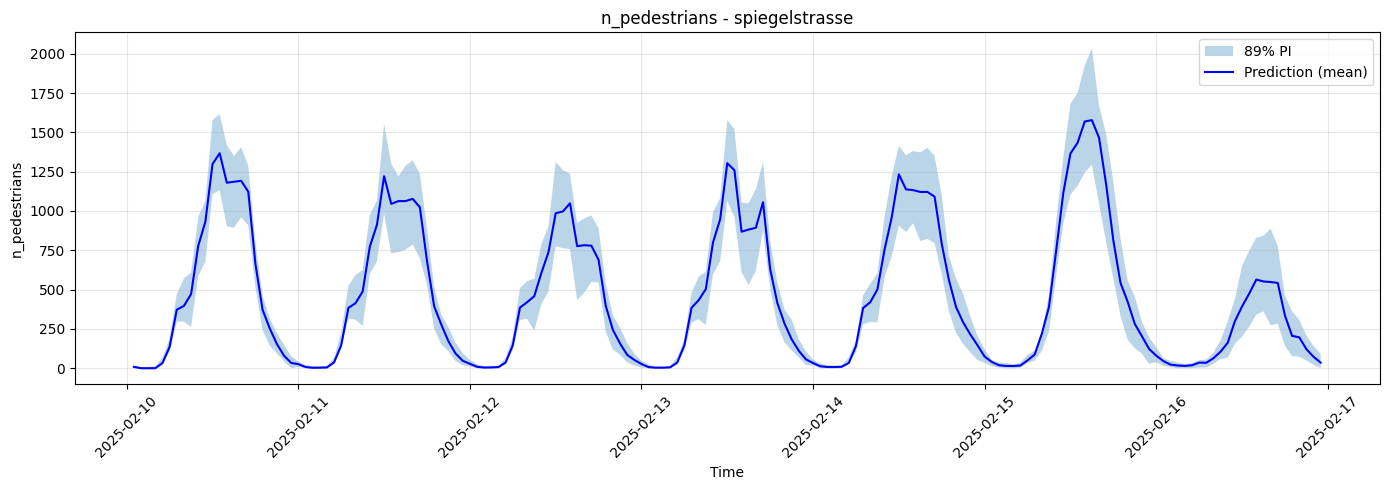

In [19]:
# Plot for test data (actuals may not be available)
plot_prediction_intervals(
    pred_results_test,
    target="n_pedestrians",
    street="spiegelstrasse",
    lower_q=0.05,
    upper_q=0.95
)

---
## 8. Optional: SHAP Analysis

Visualize feature importance using SHAP (SHapley Additive exPlanations).

In [20]:
import shap

# Select which target's model to analyze
target_to_analyze = 'n_pedestrians'

print(f"Computing SHAP values for {target_to_analyze}...")
print("This may take a few minutes.")

# Create SHAP explainer
explainer = shap.Explainer(best_models_saved[target_to_analyze])

# Compute SHAP values (use a sample for faster computation)
sample_size = min(1000, len(test_df))
test_sample = test_df[feature_cols].sample(n=sample_size, random_state=42)
shap_values = explainer(test_sample)

/Users/kaigu/miniconda3/envs/kiregio/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing SHAP values for n_pedestrians...
This may take a few minutes.


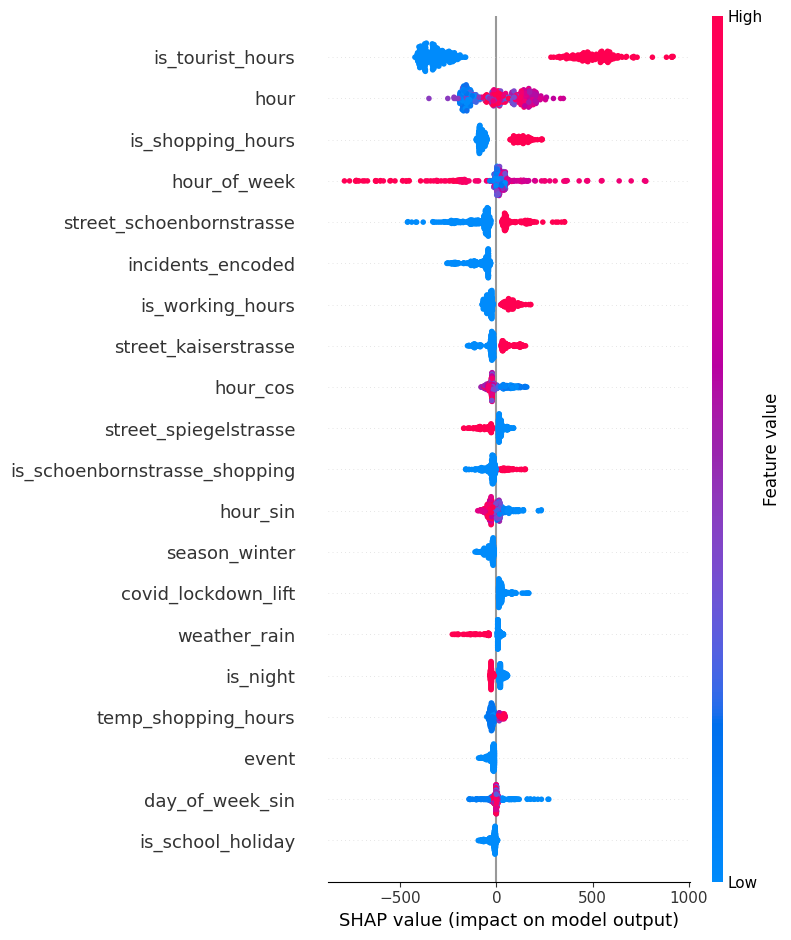

In [21]:
# Summary plot showing feature importance
shap.summary_plot(shap_values, test_sample, max_display=20)

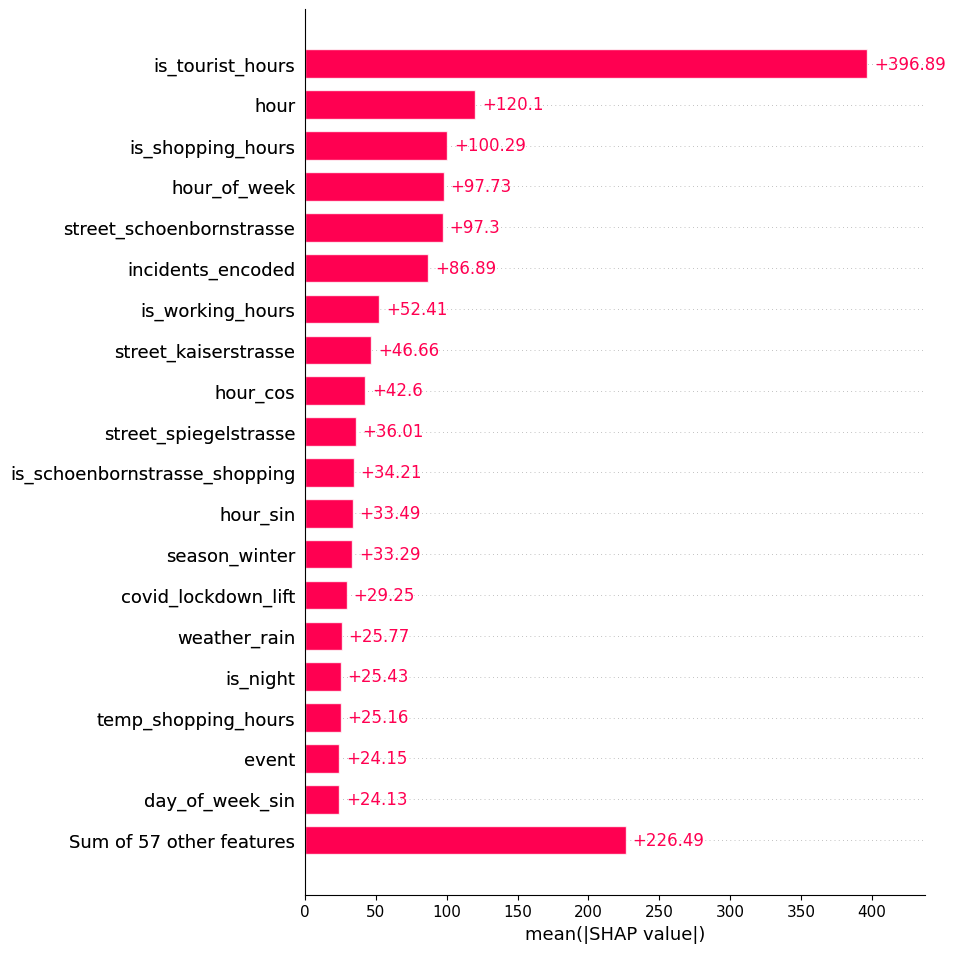

In [22]:
# Bar plot of mean absolute SHAP values
shap.plots.bar(shap_values, max_display=20)

In [ ]:
# Preview some training data
train_df.iloc[:, 0:20][-20:-15]